In [35]:
from model import *

import sys
#!{sys.executable} -m pip install [arg]

import time
import random
import numpy as np
import networkx as nx


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# 1) Construct network

In [36]:
def build_graph(n=100, m=3, p=0.5):
    G = nx.powerlaw_cluster_graph(n=n, m=m, p=p) 
    assert nx.is_connected(G)
    return G


def get_adjacency(G):
    return dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())

# 2) Define groups

In [37]:
def get_communities(G):
    return list(nx.community.label_propagation_communities(G))
 

def get_node_community_map(communities):
    node_community_map = {}
    for i,c in enumerate(communities):
        for node in c:
            node_community_map[node] = i
    return node_community_map


def get_community_membership(adjacency, node_community_map):
    membership = {i:set() for i in node_community_map}
    for i, neighbours in adjacency.items():
        for n in neighbours:
            membership[i].add(node_community_map[n])
        membership[i].add(node_community_map[i])
    return membership

# 3) Generate projects

In [38]:
def generate_projects(N, left_0=0.5, right_0=0.8, left_1=1.6, right_1=3.2):
    """
    Generate N gambles with 2 outcomes.
    """
    assert (left_0+left_1) / 2 > 1
    
    left  = np.random.uniform(left_0, right_0, N)
    right = np.random.uniform(left_1, right_1, N)
    projects = {i:(left[i],right[i]) for i in range(N)}
                
    return projects


def get_project_return(P):
    return np.random.uniform(P[0], P[1])

# 4) Maximize expected utility

In [39]:
def utility(x, w, project_uniform_bounds, safe_return, A, gamma):
    """
    Compute expected utility.
    Args:
        x : (3,) array containing [consumption_proportion, risky_invest_proportion, safe_invest_proportion]
        w : wealth level of agent
        project_uniform_bounds : tuple denoting left and right bounds of uniform random risky project return
        safe_return : amount of safe return
        A : utility function parameter
        gamma : utility function parameter
    Returns:
        best utility
    """
    r0, r1 = project_uniform_bounds
    c_prop, r_prop, s_prop = x
    
    # utility from consumption
    consumption_utility = U(w*c_prop, A=A, gamma=gamma)
    
    # best possible expected project utility
    project_utility = (1/(r1-r0)) * integrate.quad(lambda r: V(w*r_prop*r + w*s_prop*safe_return, gamma=gamma),
                                                   r0, r1)[0]
    
    return - (consumption_utility + project_utility)

In [40]:
default_gamma = 2.1
default_A = 1.2

bounds = ((0.0,1.0),(0.0,1.0),(0.0,1.0),)
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

project_bounds = (0.5, 2.5)
safe_return = 1.1

w = 1

r0, r1 = 0.5, 2.5

/Users/charlesdupont/Desktop/poverty-trap/model.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  return A*x**(1-gamma) / (1-gamma)
/Users/charlesdupont/Desktop/poverty-trap/model.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return x**(1-gamma) / (1-gamma)


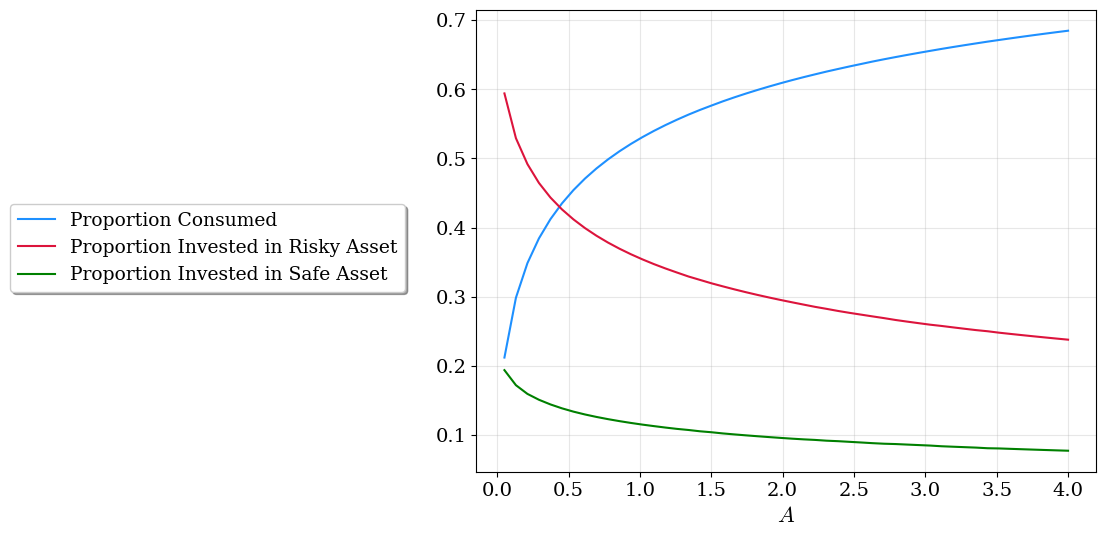

In [41]:
c = []
r = []
s = []
u = []

A_vals = np.linspace(0.05, 4, 50)
for a in A_vals:
    res = minimize(utility, x0=0.5, bounds=bounds, constraints=[cons], 
                      args=(w, (r0, r1), safe_return, a, default_gamma), method='SLSQP')

    params = res.x
    c.append(params[0])
    r.append(params[1])
    s.append(params[2])
    u.append(res.fun)    
    
plt.plot(A_vals, c, color="dodgerblue", label="Proportion Consumed")
plt.plot(A_vals, r, color="crimson", label="Proportion Invested in Risky Asset")
plt.plot(A_vals, s, color="green", label="Proportion Invested in Safe Asset")
plt.legend(bbox_to_anchor=(-0.1,0.6), shadow=True)
plt.xlabel(r"$A$")
plt.show()

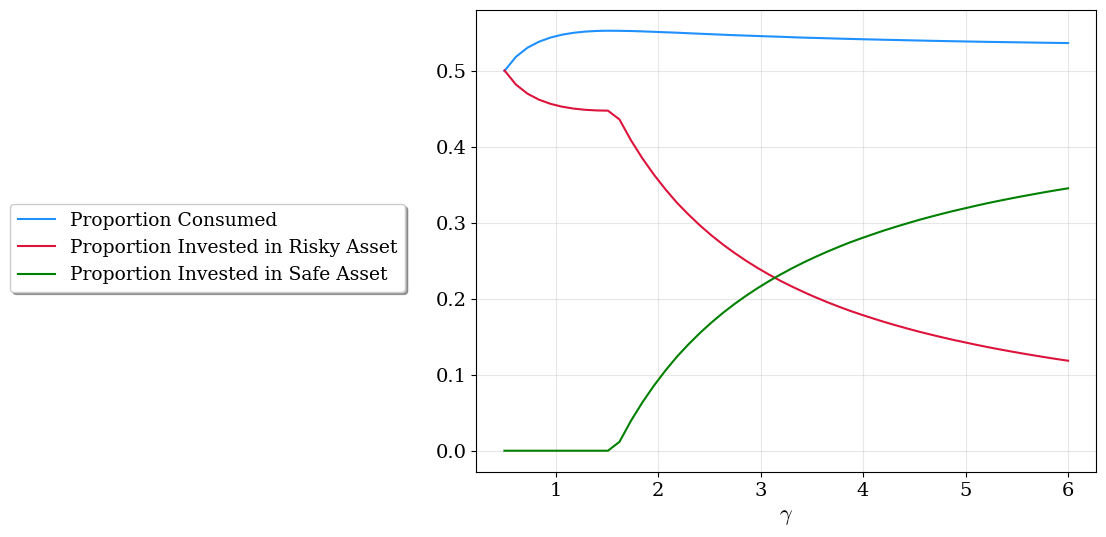

In [42]:
c = []
r = []
s = []

G_vals = np.linspace(0.5, 6, 50)
for g in G_vals:
    res = minimize(utility, x0=0.5, bounds=bounds, constraints=[cons], 
                      args=(w, project_bounds, safe_return, default_A, g), method='SLSQP').x
    c.append(res[0])
    r.append(res[1])
    s.append(res[2])
    
plt.plot(G_vals, c, color="dodgerblue", label="Proportion Consumed")
plt.plot(G_vals, r, color="crimson", label="Proportion Invested in Risky Asset")
plt.plot(G_vals, s, color="green", label="Proportion Invested in Safe Asset")
plt.legend(bbox_to_anchor=(-0.1,0.6), shadow=True)
plt.xlabel(r"$\gamma$")
plt.show()

# 5) Simulation

In [43]:
def simulation(NUM_AGENTS=500, STEPS=1, SAFE_RETURN=1.1, DEFAULT_A=1.2, 
               PROJECT_COST=3.0, W0=0.8, W1=1.2, G0=0.5, G1=3.0):
    """
    Run ABM.
    Args:
        NUM_AGENTS   : number of agents
        STEPS        : number of steps
        SAFE_RETURN  : safe return coefficient (> 1.0)
        DEFAULT_A    : parameter used in utility functions
        PROJECT_COST : minimum cost for project to be undertaken
        W0           : left bound for uniform random wealth initialization
        W1           : right bound for uniform random wealth initialization
        G0           : left bound for uniform random gamma initialization
        G1           : right bound for uniform random gamma initialization
    Returns:
        WEALTH      : (STEPS, NUM_AGENTS) array containing wealth levels of agents at each iteration
        communities : dict from community ID to list of members
    """
    
    # construct graph and adjacency matrix
    G = build_graph(n=NUM_AGENTS, m=2)
    adjacency = get_adjacency(G)
    
    # extract communities
    communities = get_communities(G)
    print(f"{len(communities)} communities.")
    
    # get community membership of nodes
    node_community_map = get_node_community_map(communities)
    community_membership = get_community_membership(adjacency, node_community_map)
    communities = {c:[] for c in range(len(communities))}
    for i, comms in community_membership.items():
        for c in comms:
            communities[c].append(i)

    # optimization bounds and constraints
    # parameters are (consumption proportion, risky proportion, safe proportion)
    bounds = ((0.0,1.0),(0.0,1.0),(0.0,1.0),)
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    
    # global attributes
    PROJECTS = generate_projects(len(communities))
    PID      = np.zeros((NUM_AGENTS), dtype=int)
    
    # agent attributes
    WEALTH = np.random.uniform(W0, W1, (STEPS+1, NUM_AGENTS))
    GAMMAS = np.random.uniform(G0, G1, NUM_AGENTS)
    C = np.zeros((NUM_AGENTS))
    R = np.zeros((NUM_AGENTS))
    S = np.zeros((NUM_AGENTS))
    PROJECT_CHOICES = [np.random.choice(list(community_membership[i]), STEPS) for i in range(NUM_AGENTS)]
    
    
    
    # metrics
    
    # TODO...
    
    
    # simulation
    for step in tqdm(range(STEPS)):

        project_contributions = np.zeros((len(PROJECTS)))

        # all agents perform optimization step and we sum up project contributions
        for i in range(NUM_AGENTS):
            p = PROJECT_CHOICES[i][step]
            c, r, s = minimize(utility, x0=[0.33, 0.33, 0.34], bounds=bounds, constraints=cons, 
                               args=(WEALTH[step][i], PROJECTS[p], SAFE_RETURN, DEFAULT_A, GAMMAS[i]), 
                               method='SLSQP').x
            C[i] = c
            R[i] = r
            S[i] = s
            PID[i] = p
            project_contributions[p] += WEALTH[step][i]*R[i]

        # run projects
        risky_returns = np.zeros((len(PROJECTS)))
        for P in PROJECTS:
            if project_contributions[P] >= PROJECT_COST:
                risky_returns[P] = get_project_return(PROJECTS[P])

        # update agent wealth
        WEALTH[step+1] = WEALTH[step] - WEALTH[step] * R + \
                         WEALTH[step] * R * risky_returns[PID] + \
                         WEALTH[step] * S * SAFE_RETURN
        
    return WEALTH, communities

In [22]:
def count_crossover_points(W, communities=None):
    """
    Count number of crossover points at agent or community level.
    Args:
        W           : (STEPS, NUM_AGENTS) array
        communities : dict from community ID to list of members (community level if this is provided)
    Returns:
        number of crossover points.
    """
    # communities is specified, so count crossover points at community-level
    if communities:
        crossover_points = {c:0 for c in range(len(communities))}
        for c, agent_list in communities.items():
            trajectory = np.mean(W[:,agent_list], axis=1)
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[c] += 1

    # otherwise count at agent level
    else:
        num_agents = W.shape[1]
        crossover_points = {a:0 for a in range(num_agents)}
        for a in range(num_agents):
            trajectory = W[:,a]
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[a] += 1
                    
    return crossover_points

In [23]:
W, communities = simulation(STEPS=10)

82 communities.


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]
